# 1. Install Dependencies and Setup

In [3]:
!pip install tensorflow opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 6.1 MB/s eta 0:00:0000:0100:01


In [5]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.1.0
aext_assistant                    0.4.0
aext_assistant_server             0.4.0
aext_core                         0.4.0
aext_core_server                  0.4.0
aext_shared                       0.4.0
aiobotocore                       2.7.0
aiofiles                          0.8.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
aiosqlite                         0.18.0
alabaster                         0.7.12
altair                            5.3.0
amqp                              5.2.0
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.4
anaconda-project                  0.11.1
anyio                             4.2.0
app                        

In [11]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [21]:
import cv2
import imghdr

In [23]:
data_dir = 'data' 

In [25]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [27]:
for image_class in os.listdir(data_dir):
    image_class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(image_class_path):
        for image in os.listdir(os.path.join(image_class_path)):
            image_path = os.path.join(image_class_path, image)
            try:
                img = cv2.imread(image_path) # reads the image in opencv
                tip = imghdr.what(image_path) # checks the extensions
                if tip not in image_exts:
                    print("Issue with image extension".format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {}'.format(image_path))
                # os.remove(image_path)

# 3. Load Data

In [29]:
import numpy as np
from matplotlib import pyplot as plt

In [32]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


python(67777) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [34]:
data_iterator = data.as_numpy_iterator()

In [36]:
batch = data_iterator.next()

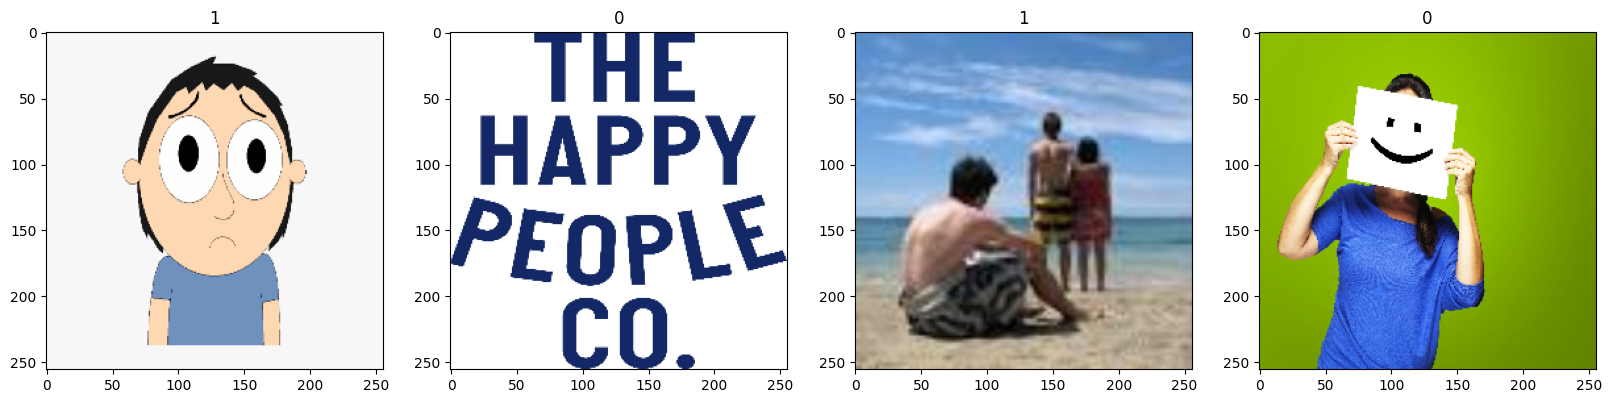

In [38]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [41]:
data = data.map(lambda x,y: (x/255, y))

In [43]:
data.as_numpy_iterator().next()

(array([[[[9.9215686e-01, 6.6274512e-01, 3.1985294e-02],
          [9.9791664e-01, 6.6066176e-01, 2.9289216e-02],
          [9.9607843e-01, 6.5882355e-01, 2.7450981e-02],
          ...,
          [9.9215686e-01, 6.6274512e-01, 3.5294119e-02],
          [9.9632353e-01, 6.6066176e-01, 3.3455882e-02],
          [9.9877453e-01, 6.6274512e-01, 3.1985294e-02]],
 
         [[9.9215686e-01, 6.6274512e-01, 3.1985294e-02],
          [9.9607843e-01, 6.5882355e-01, 2.7450981e-02],
          [9.9607843e-01, 6.5882355e-01, 2.7450981e-02],
          ...,
          [9.9215686e-01, 6.6274512e-01, 3.5294119e-02],
          [9.9632353e-01, 6.6066176e-01, 3.3455882e-02],
          [9.9877453e-01, 6.6274512e-01, 3.1985294e-02]],
 
         [[9.9877453e-01, 6.6274512e-01, 3.1985294e-02],
          [9.9240196e-01, 6.5882355e-01, 2.7450981e-02],
          [9.9607843e-01, 6.5882355e-01, 2.7450981e-02],
          ...,
          [9.9215686e-01, 6.6274512e-01, 3.5294119e-02],
          [9.9632353e-01, 6.6066176e-

# 5. Split Data

In [47]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [49]:
train_size

7

In [51]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [54]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [58]:
model = Sequential()

In [60]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [67]:
logdir='logs'

In [69]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [71]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step - accuracy: 0.4587 - loss: 1.1774 - val_accuracy: 0.5625 - val_loss: 0.6852
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 439ms/step - accuracy: 0.6070 - loss: 0.6869 - val_accuracy: 0.6406 - val_loss: 0.6710
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.6865 - loss: 0.6276 - val_accuracy: 0.6562 - val_loss: 0.5816
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - accuracy: 0.7710 - loss: 0.5267 - val_accuracy: 0.8125 - val_loss: 0.4953
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.8684 - loss: 0.4440 - val_accuracy: 0.8438 - val_loss: 0.4275
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - accuracy: 0.7783 - loss: 0.4776 - val_accuracy: 0.8281 - val_loss: 0.3756
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.8326 - loss: 0.3473 - val_accuracy: 0.9375 - val_loss: 0.2431
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.9481 - loss: 0.2258 - val_accuracy: 0.9219 - val_loss:

# 8. Plot Performance

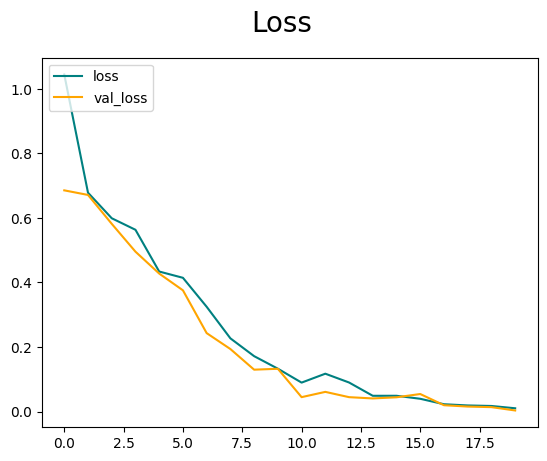

In [74]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

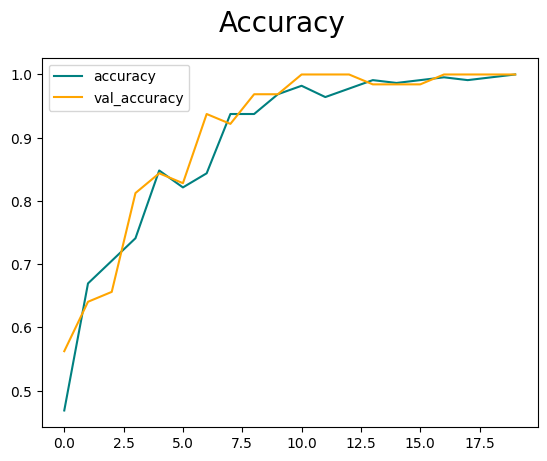

In [76]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [79]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [81]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [83]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


2024-10-11 11:21:39.364775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [85]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [88]:
import cv2

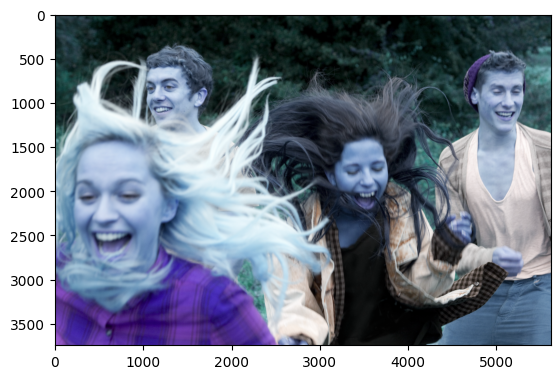

In [90]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

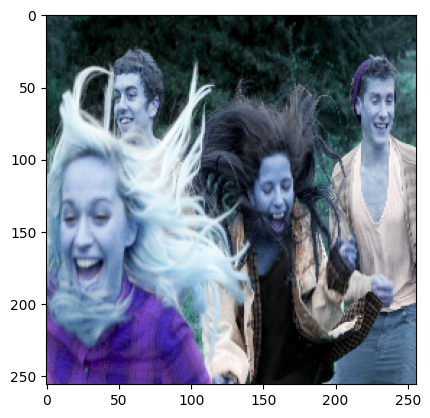

In [92]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [94]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [96]:
yhat

array([[0.10570283]], dtype=float32)

In [98]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [101]:
from tensorflow.keras.models import load_model

In [103]:
model.save(os.path.join('models','imageclassifier.h5'))

In [105]:
new_model = load_model('imageclassifier.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'imageclassifier.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)